<a href="https://colab.research.google.com/github/kcw0331/Deeplearning/blob/main/transfer_learning(%EA%B9%80%EC%B0%BD%EC%9A%B0)4%EC%9B%947%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np  #여기에서 중요한게 numpy읽어 오는거랑 
import os
import tensorflow as tf  #여기에서 중요한게 tensorflow을 읽어온거랑 

from tensorflow.keras.preprocessing import image_dataset_from_directory #여기에서 중요한게 image_dataset_from_direcctory함수를 읽어 왔다. 

- 여기에서는 필요한 모듈들을 읽어 온다. 
- image_dataset_from_directory이거는 directory를 집어 넣으면, directory로 클래스 별로 데이터로 만들어 주는 함수이다. 

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
#이런 부분을 돌리다가 궁금하면 이렇게 돌려주는 것도 좋다고 말씀하심. 
os.listdir(train_dir)
#그래서 train_dir안에 cats과 dogs가 있다는 것을 알 수 있다. 

['dogs', 'cats']

In [ ]:
#실제로 이 안에 데이터가 잘 있나 확인하기 위해서 
os.listdir(train_dir + '/cats')
#이 코드를 실행 시키면 cats directory안에 cat그림들이 있는 것을 알 수 있다.  

['cat.673.jpg',
 'cat.291.jpg',
 'cat.25.jpg',
 'cat.665.jpg',
 'cat.183.jpg',
 'cat.655.jpg',
 'cat.881.jpg',
 'cat.491.jpg',
 'cat.12.jpg',
 'cat.863.jpg',
 'cat.534.jpg',
 'cat.656.jpg',
 'cat.710.jpg',
 'cat.661.jpg',
 'cat.68.jpg',
 'cat.319.jpg',
 'cat.641.jpg',
 'cat.528.jpg',
 'cat.772.jpg',
 'cat.628.jpg',
 'cat.131.jpg',
 'cat.354.jpg',
 'cat.381.jpg',
 'cat.877.jpg',
 'cat.223.jpg',
 'cat.449.jpg',
 'cat.195.jpg',
 'cat.431.jpg',
 'cat.602.jpg',
 'cat.263.jpg',
 'cat.984.jpg',
 'cat.331.jpg',
 'cat.811.jpg',
 'cat.778.jpg',
 'cat.565.jpg',
 'cat.19.jpg',
 'cat.642.jpg',
 'cat.657.jpg',
 'cat.84.jpg',
 'cat.116.jpg',
 'cat.627.jpg',
 'cat.388.jpg',
 'cat.473.jpg',
 'cat.996.jpg',
 'cat.421.jpg',
 'cat.332.jpg',
 'cat.923.jpg',
 'cat.176.jpg',
 'cat.968.jpg',
 'cat.129.jpg',
 'cat.743.jpg',
 'cat.724.jpg',
 'cat.610.jpg',
 'cat.309.jpg',
 'cat.465.jpg',
 'cat.722.jpg',
 'cat.967.jpg',
 'cat.69.jpg',
 'cat.459.jpg',
 'cat.591.jpg',
 'cat.891.jpg',
 'cat.226.jpg',
 'cat.282.jpg'

In [ ]:
#정말 고양이 그림이 1000장 정도 있나 확인하기 위해서 
len(os.listdir(train_dir + '/cats'))
#len를 하게 되면 1000개가 있다는 것을 알 수 있다. 

1000

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


- 여기에서는 data를 받아서 preprocessing해주는 부분이다. 
- 여기에서는 image_dataset_from_directory이 directory를 사용하고 있고 train_dir를 넣어가지고 train_dir안에 있는 고양이와 개의 폴더가 있는데, 그거를 2 class로 인식한 다음에 각각 2000장의 그림이 있다 라는 것을 확인해 줄 수 있다. 
- 그리고 여기 그림은 dog 그림 1000개, cat 그림 1000개 있다는 것을 알 수 있다. 

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


- 마찬가지로 validation_dataset도 진행을 해보면, 1000개의 파일이 2개의 class로 있다는 것을 알 수 있다. 
- 아마도 cat에 500개, dog에 500개가 있는 것 같다. 

Show the first nine images and labels from the training set:

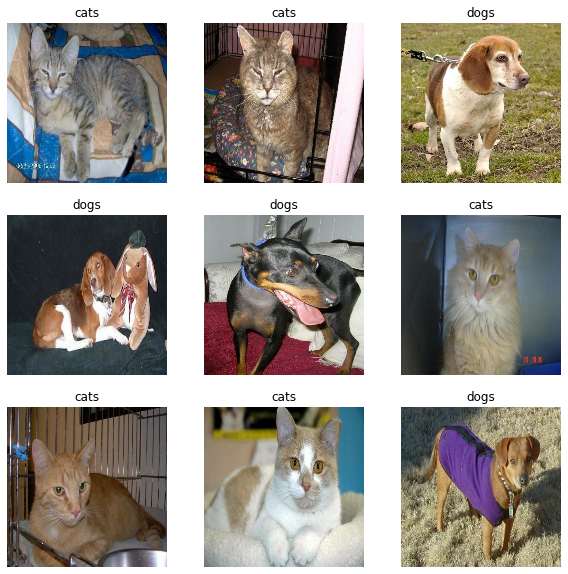

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  #그리고 train_dataset에서 한개씩(take(1)) 빼와 주면서 그림을 10개 그려줘 본다. 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

- 이렇게 10개의 그림이 그려지는 것을 볼 수 있다. 

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

- 테스트 set이 없기 때문에 여기에서는 test set을 아래 코드에서 부터 만들려고 하고 있다. 

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #validation_dataset에서 따로 떼어서 test_dataset을 만들려고 하고 있고 
test_dataset = validation_dataset.take(val_batches // 5)  #그래서 test_dataset은 validation_dataset에서 (val_batches // 5) 이정도의 비율을 따로 take해와서 test set으로 집어 넣고 
validation_dataset = validation_dataset.skip(val_batches // 5)  #validation_datset은 기존의 validation_dataset에서 skip(val_batches // 5)이 만큼을 skip한다는 얘기이다. 
#즉, validation_dataset에서 일정 비율을 test_dataset으로 사용하고, 그리고 나머지 일정 비율을 validation_dataset으로 사용을 한다. 

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


- 기존의 batches가 32개 였는데, 그 32개 중에 26개는 validation으로 사용을 하고, 6개는 test로 사용을 한다는 것이다. 

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
#여기는 data를 train할 때 추가적인 옵션들이다. prefetch을 사용해주고 그리고 여기서는 train data를 suffle도 해주면 좋다고 하심. 
#근데 여기에서는 위에 코드를 보면 shuffle=True가 되어있어서 shuffle을 안해줘도 되지만 여기에서 한번 더 shuffle을 해줌.
AUTOTUNE = tf.data.AUTOTUNE   #AUTOTUNE 으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정하도록 만듭니다.

train_dataset = train_dataset.shuffle(2000).prefetch(buffer_size=AUTOTUNE)  #우리의 train data는 2000개가 있으니깐, shuffle(2000)도 2000개를 해준다. 
#train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

- data_augmentaion과 같은 부분은 layer로 달 수가 있다. 그래서 RandomFlip이랑 RandomRotation을 해준다는 것이다. 

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

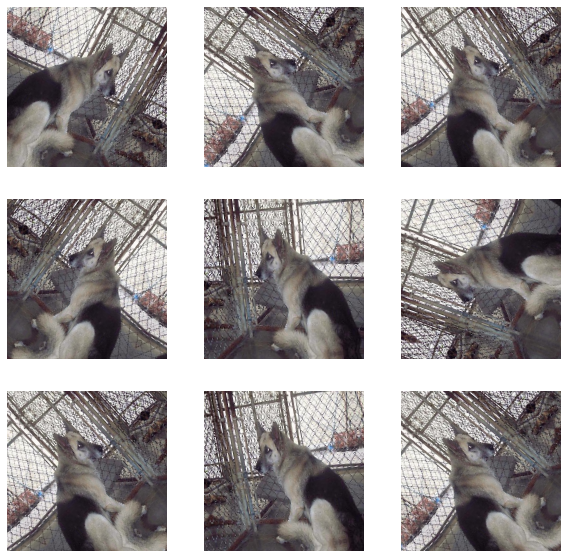

In [ ]:
for image, _ in train_dataset.take(1):  #train_dataset에서 1개를 가지고 와서 
  plt.figure(figsize=(10, 10))
  first_image = image[0]  #first_image는 0이고, 그래서 첫번째 image를 빼와서 data_augmentation을 적용한 그림이다. 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) #그러면 first augmentation을 적용을 한 다음에 이제 그림을 그려보면 
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

- 여기에서는 data_augmentation이 적용이 된것을 그림으로 그려보고 싶어서 위의 코드를 사용해서 그림을 그려준다. 
- 똑같은 그림을 data_augmentationd을 해줘서 9장의 그림이 나오는 것을 볼 수 있다. 

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input  

- preprocess_input이거는 mobilenet_v2에서 preprocess_input하는 과정을 이렇게 모듈로 만들어서 그래서 불러오기 전에 preprocess을 해준다.

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

- 그리고 rescale과 같은 경우는 기존에 책에서 배운 방법은 255로 나눈 방법이였는데, 여기와 같은 경우에는 127.5를 나눈다음에 -1을 해줘서 값이 -1에서 1사이가 되도록 맞춰주게 된다. 

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


- 책에서 보았던 것은 VGG16을 사용했는데, 여기에서는 MobileNetV2 이거를 사용하고 있다. 
- image shape은 160, 160
- 그리고 iclude_top을 False로 해서 마지막 classification layer를 빼주고, 그리고 weights는 imagenet을 사용해준다. 

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))  #이거는 tain_dataset이라는 generator를 통해서 이미지 데이터랑 이미지 데이터 라벨 한장 정도를 빼와서 이 한장에다가 base 모델을 돌려가지고 
#feature_batch 즉 MobileNetV2을 하나 통과 시켜가지고 그 feature가 어떻게 나오는지 그 feature의 shape을 보는 것이다. 
feature_batch = base_model(image_batch)  #그리고 base_model에 image를 넣어서 
print(feature_batch.shape)

(32, 5, 5, 1280)


- 첫번째 batch에 32개씩 뽑아 있으니깐, input은 32, 160, 160, 3이 되었는데, 그거를 가지고 MobileNetV2돌려가지고 32, 5, 5, 1280의 output이 나온 것을 알 수 있다. 
- 이거는 feature의 dimension을 확인한 정도이다. 

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

- 우리가 하려는 transfor learning에서는 base_model에 trainable한 것을 False해서 train하지 않도록 False를 시켜주는 작업이 필요하다. 

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

- base_model.summary()이것을 살펴보면, 이게 MobileNetV2의 구조이다. VGG16보다 더 복잡한 것을 볼 수 있다. 그래서 layer가 많다는 것을 볼 수 있다.

### Add a classification head

- 이제 여기에서는 classification head들을 달거다.

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)  #그래서 global_average한 결과를 살펴보기 위해 global_average_layer(feature_batch)이거를 집어 넣어서 
#사이즈가 (32, 1280)이 나오는 것을 볼 수 있다. 
print(feature_batch_average.shape)

(32, 1280)


- 책에서는 reshape하는 식으로 flatten시켰고, 여기에서는 GlobalAveragePooling2D이것을 해주었다. 
- GlobalAveragePooling2D은 (32, 5, 5, 1280)에서 5, 5를 평균을 내서 1280개의 feature로 만들어 준다는 것이다. 
- 그냥 faltten 시키는 것을 5, 5, 1280을 쭉나열해서 5 * 5 * 1280개 해서 쭉 faltten 시키는 거고, GlobalAveragePooling2Ddms 5,5를 평균을 내서 1280번해서 쭉 나오게 된다. 

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)   #그리고 여기에 Dense layer를 달아가지고 그리고 개 아니면 고양이여야 하니깐 Dense layer를 (1)만 달았다. 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)  #prediction layer된다. 
#그래서 이렇게 해서 모형을 완성을 한다. 

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))  #keras의 input은 160, 160, 3이 된다. 
x = data_augmentation(inputs)  #data_augmentation을 달아가지고 이미지가 들어 왔을때, 그 이미지에 data_augmentation을 적용을 하고 
x = preprocess_input(x)  #그리고 data_augmentaion을 적용한 거에 mobilenet에 들어가는 그림을 preprocess해주고  
x = base_model(x, training=False) #preprocess된 거를 mobilnet모듈에 집어 넣어주고 
x = global_average_layer(x)  #mobilnet에서 나온것을 global_average_layer를 해줘서 1000 얼마의 차원으로 바꾸어 준다음에 
x = tf.keras.layers.Dropout(0.2)(x) #그다음에 Dropout을 달고 
outputs = prediction_layer(x)  #그리고 prediction_layer를 달아가지고 
model = tf.keras.Model(inputs, outputs) #모형을 완료해준다. 

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), #모형을 compile해주는데 optimizer는 Adam으로 해준다. 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #loss는 BinaryCrossentropy를 사용하였고
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

- model.summary()이렇게 하면 모형 형식을 볼 수 있다. 
- 여기에서 더 자세하게 보려면 base_model.summary()를 하게 되면, 더 자세한 내용을 볼 수 있다.  

- Total params: 2,259,265 이렇게 되는 것을 볼 수 있다.
- Trainable params: 1,281 이렇게 되는 것을 볼 수 있다.

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)  #initial loss랑 initial accuracy를 찍어 준 다음에 그 다음에 모형을 피팅 해준다. 

26/26 [==============================] - 5s 70ms/step - loss: 0.8554 - accuracy: 0.4258


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.43


In [ ]:
#10단계를 하게 되면 loss와 accuracy가 점차 올라가는 것을 볼 수 있다. 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 94ms/step - loss: 0.8139 - accuracy: 0.4930 - val_loss: 0.6048 - val_accuracy: 0.6052
Epoch 2/10
63/63 [==============================] - 9s 89ms/step - loss: 0.5962 - accuracy: 0.6675 - val_loss: 0.4508 - val_accuracy: 0.7240
Epoch 3/10
63/63 [==============================] - 9s 88ms/step - loss: 0.4861 - accuracy: 0.7415 - val_loss: 0.3563 - val_accuracy: 0.7834
Epoch 4/10
63/63 [==============================] - 9s 88ms/step - loss: 0.4105 - accuracy: 0.7950 - val_loss: 0.2932 - val_accuracy: 0.8366
Epoch 5/10
63/63 [==============================] - 9s 89ms/step - loss: 0.3495 - accuracy: 0.8305 - val_loss: 0.2560 - val_accuracy: 0.8601
Epoch 6/10
63/63 [==============================] - 9s 90ms/step - loss: 0.3170 - accuracy: 0.8425 - val_loss: 0.2163 - val_accuracy: 0.8886
Epoch 7/10
63/63 [==============================] - 9s 88ms/step - loss: 0.2944 - accuracy: 0.8620 - val_loss: 0.1904 - val_accuracy: 0.9035
Epoch 8/10
6

- 이게 끝이 나면 모형이 잘 학습이 되었는지 그래프를 통해 알 수 있다. 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

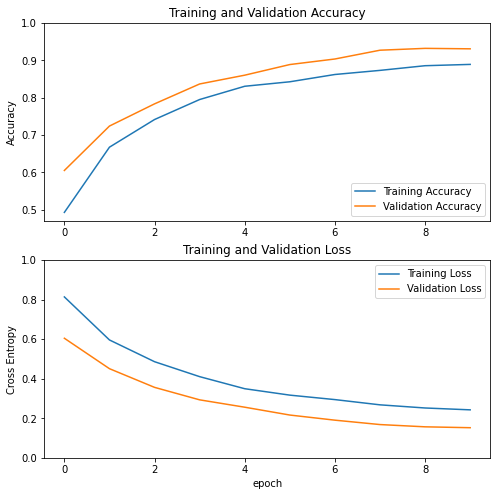

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- 파란색이 train_accuracy이고, 주황색이 validatio_accuracy인데, 신기하게 validation_accuracy가 더 좋은 것을 볼 수 있다. 
- 그래서 validation_accuracy가 95%로 잘 training되고 있는 것을 볼 수 있다. 
- Cross Entropy 도 그림으로 보았을때 잘 fitting되는 것을 볼 수 있어서 overfitting되고 있지 않는 것을 볼 수 있다. 
- 그래서 training이 잘 되는 것을 확인 할 수 있었다 

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning  <-여기에서는 Fine tuning에 대한 부분이 나온다. 
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True  #base_model.trainable이것을 True로 바꾸어준고 

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100  #fine_tune_at이걸 100으로 해서 100번째 이후에 애들을 풀어준다. 그래서 걔네들을 trainable하게 바꾸어 주겠다는 것이다. 

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False  #그리고 여기에서는 fine_tune_at을 100까지를 layer.trainable = False로 바꾸어줘서 아까 했던 작업이랑 비슷하게 된다. 

Number of layers in the base model:  154


- 그러니깐, 154개가 있으면 100번째 layer 부터 나머지 154번째 layer까지 layer.trainable을 True로 바꾸어서 더 Fine tune할 수 있게 해준다.

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

- Trainable params: 1,862,721이게 이전에는 1,281였는데, 지금은 1,862,721로 많이 늘어난 것을 볼 수 있다. 

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
history.epoch[-1]  #<- 이게 내가 기존 history epoch을 어디까지 했나이다.

9

In [ ]:
fine_tune_epochs = 10   #fine_tune_epochs는 10개가 되고 
total_epochs =  initial_epochs + fine_tune_epochs #total_epochs는 initial_epochs 더하기 fine_tune_epochs이 된다. 

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],  #그래서 9까지이니깐 9에서부터 epochs을 시작해라 하는 것이다. 
                         validation_data=validation_dataset)
#그래서 epochs은 10부터 시작되는 것을 볼 수 있다. 

Epoch 10/20
63/63 [==============================] - 17s 134ms/step - loss: 0.1778 - accuracy: 0.9241 - val_loss: 0.0650 - val_accuracy: 0.9703
Epoch 11/20
63/63 [==============================] - 10s 115ms/step - loss: 0.1209 - accuracy: 0.9498 - val_loss: 0.0519 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 10s 114ms/step - loss: 0.1059 - accuracy: 0.9568 - val_loss: 0.0420 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 10s 113ms/step - loss: 0.0835 - accuracy: 0.9608 - val_loss: 0.0463 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 10s 114ms/step - loss: 0.0969 - accuracy: 0.9577 - val_loss: 0.0429 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 10s 114ms/step - loss: 0.0794 - accuracy: 0.9719 - val_loss: 0.0439 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 10s 116ms/step - loss: 0.0666 - accuracy: 0.9733 - val_loss: 0.0370 - val_accuracy:

- fine tune을 통해서 기본의 loss와 accuracy가 1~2%가 증가한 것을 볼 수 있다. 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

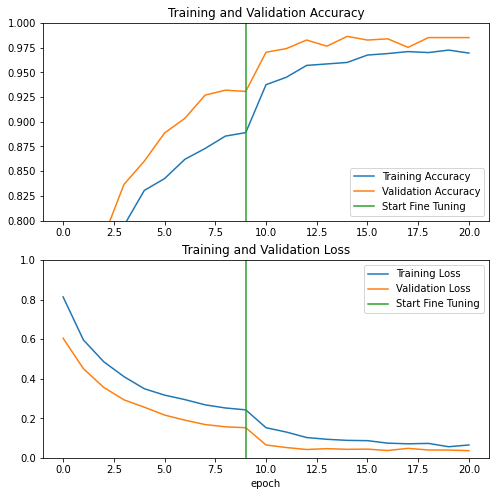

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- 그림을 그려보았을 때 overfitting되는 것을 볼 수 없다. 
- fine tuning은 초록색 선부터 진행이 된것을 볼 수 있다. 

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)  #결과적으로 evaluate을 가지고 test set에 대한 결과를 살펴보면 
#test accuracy가 97%정도 나온다는 것을 확인 할 수 있다. 

6/6 [==============================] - 1s 74ms/step - loss: 0.0619 - accuracy: 0.9688
Test accuracy : 0.96875


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1]
Labels:
 [0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1]


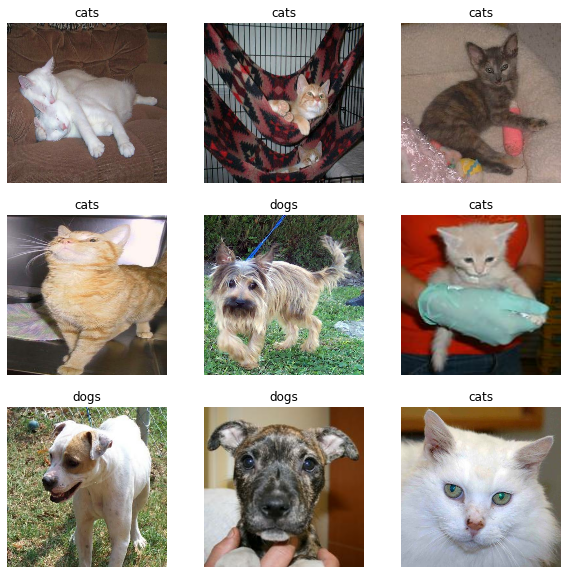

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

- 고양이와 개의 그림을 그려주고 틀린그림이 있나 볼 수 있다. 
- 이렇게 해서 프로젝트나 모형을 검증할 때, 하면 된다고 하심.

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
